---
author: 
  - name: Matthew Reda
    email: redam94@gmail.com
copyright: 
  holder: Matthew Reda
  year: 2024
citation: true
---

# Optimizer

> Optimizers for models

In [ ]:
#| default_exp optimizer

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [ ]:
#| export
import numpy as np
import xarray as xr
import pandas as pd
import scipy.optimize as opt
import optuna

from budget_optimizer.utils.model_classes import BaseBudgetModel
from budget_optimizer.utils.model_helpers import (
  load_module,
  load_yaml,
  BudgetType, 
  AbstractModel
)
from budget_optimizer.utils.search_space_helper import ConstrainedSearchSpace
from pathlib import Path
from abc import ABC, abstractmethod

In [ ]:
#| export
class BaseOptimizer(ABC):
    """Optimizer wrapper for the pyswarms package"""
    _CONFIG_YAML = 'optimizer_config.yaml'
    _MODULE_FILE = "optimizer_config.py"
    
    def __init__(
        self, 
        model: BaseBudgetModel, # The model to optimize
        config_path: str|Path # Path to the configuration files
        ):
        
        self.model: BaseBudgetModel = model
        self._config_path: Path = Path(config_path) if isinstance(config_path, str) else config_path
        self.optimal_budget: BudgetType = None
        self.optimal_prediction: xr.DataArray = None
        self.optimal_contribution: xr.Dataset = None
        self.sol = None
        self._config = self._load_config()
        self._loss_fn = self._load_loss_fn()
        self._optimizer_array_to_budget = self._load_optimizer_array_to_budget()
        
    def _load_config(self):
        config = load_yaml(self._config_path / self._CONFIG_YAML)
        return config
    
    def reload_config(self):
        self._config = self._load_config()
        return self
    
    def _load_loss_fn(self):
        """Load the loss function from the config file"""
        module = load_module(self._MODULE_FILE.replace(".py", ""), self._config_path / self._MODULE_FILE)
        return module.loss_fn
    
    def _load_optimizer_array_to_budget(self):
        """Convert the optimizer array to a budget"""
        module = load_module(self._MODULE_FILE.replace(".py", ""), self._config_path / self._MODULE_FILE)
        return module.optimizer_array_to_budget
    
    def _optimizer_fn(self, x: np.ndarray):
        """Optimizer step"""
        budget = self._optimizer_array_to_budget(x)
        prediction = self.model.predict(budget)
        loss = self._loss_fn(prediction, **self._config['loss_fn_kwargs'])
        return loss
    
    @abstractmethod
    def optimize(
        self, 
        bounds: list[tuple[float, float]], # Bounds for the optimizer
        constraints: None|opt.LinearConstraint|tuple[float, float] = None, # Constraints for the optimizer
        **kwargs: dict # Additional arguments for the optimizer
        ):
        """Optimize the model"""
        raise NotImplementedError("This method should be implemented in the child class")

In [ ]:
#| export
class ScipyBudgetOptimizer(BaseOptimizer):
    """Optimizer wrapper for the pyswarms package"""
    
    def optimize(
        self, 
        bounds: list[tuple[float, float]], # Bounds for the optimizer
        constraints: None|opt.LinearConstraint, # Constraints for the optimizer
        init_pos: np.ndarray, # Initial position of the optimizer
        ):
        """Optimize the model"""
        import warnings
        warnings.filterwarnings("ignore")
        self.sol = opt.minimize(
            self._optimizer_fn, init_pos,
            method='trust-constr', 
            bounds=bounds, 
            constraints=constraints
            )
        if not self.sol.success:
            raise Exception(f"Optimization failed: {self.sol.message}")
        
        self.optimal_budget = self._optimizer_array_to_budget(self.sol.x)
        self.optimal_prediction = self.model.predict(self.optimal_budget) # The optimizer minimizes the cost, so we need to negate it
        self.optimal_contribution = self.model.contributions(self.optimal_budget)
        return self

In [ ]:
class BudgetModel(BaseBudgetModel):
    """
    Budget model class
    """
    ...

In [ ]:
fast_model = BudgetModel("Revenue Model", "Revenue", "../example_files/fast_model")

In [ ]:
init_budget = np.array([2, 3])
bounds = [(3, 5), (3, 5)]
constraints = opt.LinearConstraint([[1, 1]], [8], [8])
o = ScipyBudgetOptimizer(fast_model, "../example_files")

In [ ]:
show_doc(ScipyBudgetOptimizer.optimize)

---

[source](https://github.com/redam94/budget_optimizer/blob/main/budget_optimizer/optimizer.py#L87){target="_blank" style="float:right; font-size:smaller"}

### ScipyBudgetOptimizer.optimize

>      ScipyBudgetOptimizer.optimize (bounds:list[tuple[float,float]],
>                                     constraints:None|scipy.optimize._constrain
>                                     ts.LinearConstraint,
>                                     init_pos:numpy.ndarray)

*Optimize the model*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| bounds | list | Bounds for the optimizer |
| constraints | None \| scipy.optimize._constraints.LinearConstraint | Constraints for the optimizer |
| init_pos | ndarray | Initial position of the optimizer |

In [ ]:
o_fitted = o.optimize(bounds, constraints, init_pos=init_budget)

In [ ]:
#| echo: false
o_fitted.sol

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: -601.6849021505009
                 x: [ 3.168e+00  4.832e+00]
               nit: 15
              nfev: 30
              njev: 10
              nhev: 0
          cg_niter: 9
      cg_stop_cond: 1
              grad: [-1.485e+01 -1.485e+01]
   lagrangian_grad: [-9.561e-09  9.561e-09]
            constr: [array([ 8.000e+00]), array([ 3.168e+00,  4.832e+00])]
               jac: [array([[ 1.000e+00,  1.000e+00]]), array([[ 1.000e+00,  0.000e+00],
                           [ 0.000e+00,  1.000e+00]])]
       constr_nfev: [0, 0]
       constr_njev: [0, 0]
       constr_nhev: [0, 0]
                 v: [array([ 1.485e+01]), array([-1.731e-04,  1.731e-04])]
            method: tr_interior_point
        optimality: 9.56122952780968e-09
  constr_violation: 0.0
    execution_time: 0.07007312774658203
         tr_radius: 29797.67905015749
    constr_penalty: 1.0
 bar

In [ ]:
#| echo: false
print("Optimal budget:")
print({key: np.round(value, 2) for key, value in o_fitted.optimal_budget.items()})

Optimal budget:
{'a': 3.17, 'b': 4.83}


In [ ]:
#| export
from typing import Literal

In [ ]:
#| export
class OptunaBudgetOptimizer(BaseOptimizer):
    def __init__(
        self, 
        model: BaseBudgetModel, # The model to optimize
        config_path: str|Path, # Path to the configuration files
        objective_name: str = "loss", # Name of the objective
        direction: Literal["maximize", "minimize"] = "maximize", # Direction of the optimization
        sampler: optuna.samplers.BaseSampler = optuna.samplers.TPESampler, # Sampler for the optimization
        pruner: optuna.pruners.BasePruner|None = None, # Pruner for the optimization
        tol: float = 1e-3, # Tolerance for the constraints
        percent_out_tolerance: float = 0.1, # Percentage of the budget trials that can be outside the constraints
        sampler_kwargs: dict|None = None, # Additional arguments for the sampler
        pruner_kwargs: dict|None = None, # Additional arguments for the pruner
        ):
        super().__init__(model, config_path)
        self.objective_name = objective_name
        self.study = None
        self._direction = direction
        self.__tol = tol
        self.__percent_out_tolerance = percent_out_tolerance
        self.__sampler = sampler(**sampler_kwargs)
        self.__pruner = pruner(**pruner_kwargs) if not pruner is None else None
        
        
    #def _constraints(self, trial):
    #    return trial.user_attrs["constraint"]
    
    
    def _opt_fn(self, trial):
        budget = self.search_space(trial)
        #budget = self._optimizer_array_to_budget([budget[name] for name in ])
        total_budget = sum(v for v in budget.values())
        
        trial.set_user_attr("budget", budget)
        trial.set_user_attr("total_budget", total_budget)
        prediction = self.model.predict(budget)
        
        
        loss = -self._loss_fn(prediction, **self._config['loss_fn_kwargs'])
        return loss
        
        

    def optimize(
        self, 
        bounds: dict[str, tuple[float, float]], # Bounds for the optimizer
        constraints: None|tuple = None, # Constraints for the optimizer
        timeout: int = 60,
        n_trials: int = 100,
        storage: str|None = "sqlite:///db.sqlite3",
        study_name: str = "optimizer",
        n_jobs: int = 1
    ):
        """Optimize the model"""
            
        self.study = optuna.create_study(
            storage=storage,  # Specify the storage URL here.
            study_name=study_name,
            direction=self._direction,
            sampler=self.__sampler,
            pruner=self.__pruner)
        self.study.set_metric_names([self.objective_name])
        if constraints is None:
            constraints = (-np.inf, np.inf)
        self.search_space = ConstrainedSearchSpace(bounds, constraints)
        self.study.optimize(
            self._opt_fn, 
            n_trials=n_trials, 
            timeout=timeout,
            n_jobs=n_jobs)
        
        self.sol = self.study.best_trial
        self.optimal_budget = self.sol.params
        self.optimal_prediction = self.model.predict(self.optimal_budget)
        

In [ ]:
#| echo: false
from datetime import datetime

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
slow_model = BudgetModel("Revenue Model", "Revenue", "../example_files/slow_model")
opt_optimizer = OptunaBudgetOptimizer(
  slow_model, "../example_files", 
  direction="maximize", tol=1e-3, percent_out_tolerance=0.1,
  sampler_kwargs={"multivariate": True, "group": True})
bounds = {"a": (3, 8), "b": (3, 5)}
constraints = (8, 8)
now = datetime.now()
opt_optimizer.optimize(
  bounds, constraints, 
  n_trials=200_000, timeout=30, 
  storage="sqlite:///db.sqlite3", 
  study_name=f"optimizer - {now}", 
  n_jobs=4)

In [ ]:
o_fitted.optimal_budget

{'a': 3.1675802082673, 'b': 4.8324197917327005}

In [ ]:
#|echo: false
print("Scipy Optimal Total Budget", float(sum(o_fitted.optimal_budget.values())))

Scipy Optimal Total Budget 8.0


In [ ]:
#|eval: false
opt_optimizer.optimal_budget

{'b': 4.823127132486017, 'a': 3.176872867513983}

In [ ]:
#|echo: false
print("Optuna Optimal Total Budget", float(sum(opt_optimizer.optimal_budget.values())))

Optuna Optimal Total Budget 8.0


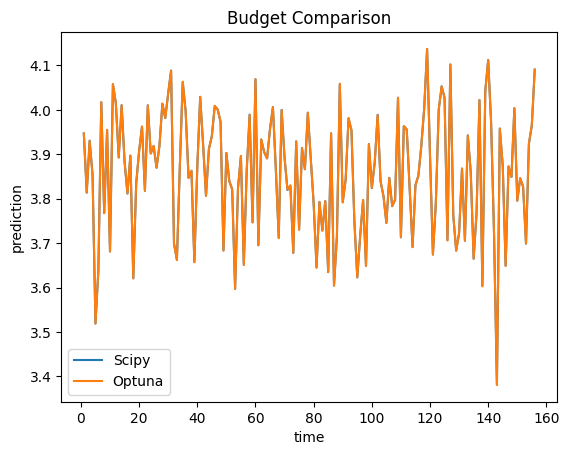

In [ ]:
#| echo: false
#m.predict({'a': 2, 'b': 3}).plot(label="Initial")
#m.predict({'a': 1.8, 'b': 3.2}).plot(label="Max B")
#m.predict({'a': 2.2, 'b': 2.8}).plot(label="Max A")
o_fitted.optimal_prediction.plot(label="Scipy")
opt_optimizer.optimal_prediction.plot(label="Optuna")
plt.title("Budget Comparison")
plt.legend();

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()